# Introduction to Machine Learning via Nearest Neighbors

## Part 1 - Implement k-Nearest Neighbors (kNN) - 30 points

Note: This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parametric** learning algorithm called k-Nearest Neighbors (kNN), and will implement it. You will then analyze the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificially generated data.

### k-Nearest Neighbors (kNN)

The kNN algorithm is simple - given a labeled set of samples, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbors in the dataset.

kNN.png

### Implement kNN

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should receive the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]).
- `predict`: should receive a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set.

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

* Bonus for nerds: use kd-tree for efficiency, see [nearest neighbor search in wiki](https://en.wikipedia.org/wiki/Nearest_neighbor_search)

* Bonus for lazy nerds: use [scipy's kd implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html)

In [1]:
import numpy as np


class KNNClassifier:
    """k-Nearest Neighbors classifier."""

    def __init__(self, k_neighbors: int) -> None:
        """Initialize the k-Nearest Neighbors classifier.

        Parameters
        ----------
        k_neighbors : int
            Number of neighbors to use for prediction.
        """
        self.k = k_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Train the classifier.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_features)
            Training data. Each row represents one sample with n_features dimensions.
        y : np.ndarray of shape (n_samples,)
            Target labels (0 or 1) for the training data.

        Returns
        -------
        None
        """
        self.X_train = X
        self.y_train = y


    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict labels for test data using k-Nearest Neighbors classification.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_features)
          Test samples to predict. Must have the same number of features
          as the training data.

        Returns
        -------
        np.ndarray of shape (n_samples,)
          Predicted labels (0 or 1) for each test sample, determined by majority vote
          of the k nearest neighbors using Euclidean distance.
          Earlier training points are preferred when distances are equal.
          In case of tied votes, either label may be returned.
        """

        def find_class_for_a_row(row, X_arr):

            distances = np.sqrt(np.sum((X_arr - row) ** 2, axis=1))
            smallest_values_indexes = np.argpartition(distances, self.k)[:self.k]
            classes = self.y_train[smallest_values_indexes]
            values, counts = np.unique(classes, return_counts=True)

            most_common_value = values[np.argmax(counts)]
            return most_common_value


        y_pred = np.array([find_class_for_a_row(row, self.X_train) for row in X])
        return y_pred



## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** algorithm because it doesn't learn fixed parameters from the training data - instead, it stores the entire training set to make predictions. The number of effective parameters grows with the training set size. While no model parameters are learned during training, the number of neighbors **$k$ is a hyperparameter** that must be chosen before training. Selecting the optimal value of $k$ involves balancing the bias-variance trade-off as discussed in class.

### An applied example: voter party registration (synthetic dataset)

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democratic voter.

Use the given function `generate_data(m)` to create m samples with their corresponding labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effects of features that are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def true_boundary_voting_pred(wealth: np.ndarray, religiousness: np.ndarray) -> np.ndarray:
    """Calculate true decision boundary for voter prediction."""
    return religiousness - 0.1 * ((wealth - 5)**3 - wealth**2 + (wealth - 6)**2 + 80)


def generate_data(m: int, seed: None | int = None) -> tuple[np.ndarray, np.ndarray]:
    """Generate synthetic voter data with random noise.

    Parameters
    ----------
    m : int
        Number of samples to generate
    seed : int, optional
        Random seed for reproducibility

    Returns
    -------
    X : np.ndarray of shape (m, 2)
        Features (wealth, religiousness)
    y : np.ndarray of shape (m,)
        Labels (1 for Republican, -1 for Democrat)
    """
    # if seed is not None, this function will always generate the same data
    np.random.seed(seed)

    # Generate m samples with wealth & religiousness features, each ~U[0,10]
    X = np.random.uniform(low=0.0, high=10.0, size=(m,2))

    # Calculate labels (1=Republican, -1=Democrat) using boundary function
    y = np.sign(true_boundary_voting_pred(X[:, 0], X[:, 1]))
    y[y == 0] = 1  # Set edge case of 0 to Republican

    # Flip random 0-10% of labels to add noise
    samples_to_flip = np.random.randint(0, m//10)
    flip_ind = np.random.choice(m, samples_to_flip, replace=False)
    y[flip_ind] = -y[flip_ind]

    return X, y


def plot_labeled_data(X: np.ndarray, y: np.ndarray, no_titles: bool = False) -> None:
    """Plot voter data with party affiliations and decision boundary.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, 2)
        Voter features
    y : np.ndarray of shape (n_samples,)
        Party labels
    no_titles : bool, default=False
        If True, omit plot titles and labels
    """
    republicans = (y == 1)
    democrats = (y == -1)

    plt.scatter(X[republicans, 0], X[republicans, 1], c='r')
    plt.scatter(X[democrats, 0], X[democrats, 1], c='b')

    if not no_titles:
      plt.xlabel('Wealth')
      plt.ylabel('Religiousness')
      plt.title('Red circles represent Republicans, Blues Democrats')

    plt.xlim([0, 10])
    plt.ylim([0, 10])
    plt.plot(np.linspace(0, 10, 1000), -true_boundary_voting_pred(np.linspace(0, 10, 1000), np.zeros(1000)), linewidth=2, c='k');


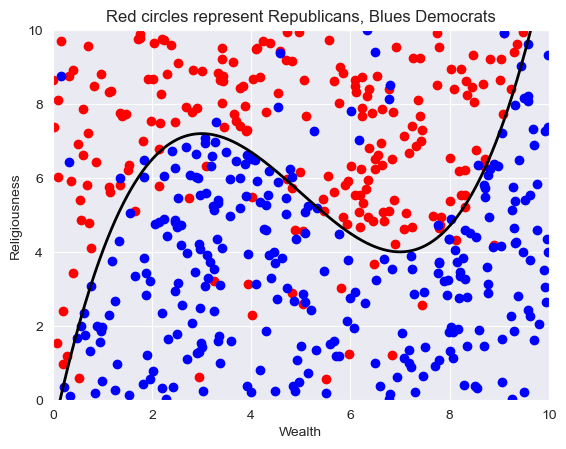

In [4]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)

### 1. Analyze the properties of kNN - 30 points

Generate multiple sample data sets of size 500 (use the given function above), and plot the decision boundary for increasing values of $k$ (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision boundary should cover the range [0, 10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like this:

![decision boundary](https://drive.google.com/uc?export=view&id=1jMD7I9sWT4w4O48pjwSPCFL1NLLPo10j)


Hint: check [contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html)



Answer the following questions:
- How do changes in the sample set affect the decision boundary, as a function of k?
- Can you describe when you underfit or overfit the data?
- How does the complexity of this model depend on $k$?

- Bonus for nerds:
Use interactive slider for k to see the effect [see [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)]

In [5]:
from ipywidgets import interact
def plot_decision_boundary(k=1):
    X, y = generate_data(500, 42)
    y = (y + 1) / 2 # from -1 to 0 =)
    y = y.astype(int)
    knn = KNNClassifier(k)
    knn.fit(X, y)

    xx, yy = np.meshgrid(np.linspace(0, 10, 200), np.linspace(0, 10, 200))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.7, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=plt.cm.coolwarm)
    plt.plot(np.linspace(0, 10, 1000), -true_boundary_voting_pred(np.linspace(0, 10, 1000), np.zeros(1000)), linewidth=2, c='k');
    plt.title(f"Decision Boundary for k = {k}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.colorbar(label="Class")
    plt.grid()
    plt.show()

# Interactive slider for k
interact(plot_decision_boundary, k=(1, 99, 2));

interactive(children=(IntSlider(value=1, description='k', max=99, min=1, step=2), Output()), _dom_classes=('wi…

Q1: How do changes in the sample set affect the decision boundary, as a function of k?

A1 : For small k, islands are formed around the points that are noise, and if the object falls into them, it will be incorrectly classified. In this case, the variance of the predictions will be high. As k increases, the islands disappear, and the boundary between the positive and negative classes begins to repeat the theoretical boundary. When k becomes very large, the islands disappear and the boundary stops repeating the shape of the theoretical one, the bias increases.

Q2: Can you describe when you underfit or overfit the data?

A2: Probably the best way to estimate when a model is overfitting is to look at the training sample to see how bias and variance change. But you can also think differently: for small k, we overfit and mistake noise for patterns; for too large k, we can ignore local patterns in the data.

Q3: How does the complexity of this model depend on  k ?

A3: For small k, the model is more complex, if only because the variance of predictions increases. For large k, the deviation from the target function increases.



### 2. Finding the optimal k - 15 points

Draw a single dataset of size 1000 and divide it randomly into training (60%), validation (20%), and test (20%) sets. Plot the training versus validation error for several $k$ values, and choose the best $k$. Where do you underfit / overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set. What would happen if you optimize directly on the test set? Is the optimal $k$ the same?

In [365]:
# dataset size 1000
X, y = generate_data(1000, 42)
# random split
indices = np.arange(len(X))
np.random.shuffle(indices)

n_folds = 5

X = X[indices]
y = y[indices]

y = ((y + 1) / 2).astype(int) # minus one to zero appropriate to my knn =)

X_split = np.array_split(X, n_folds)
y_split = np.array_split(y, n_folds)

X_train, X_val, X_test = np.concatenate(X_split[:3]), X_split[3], X_split[4]
y_train, y_val, y_test = np.concatenate(y_split[:3]), y_split[3], y_split[4]

k_range = np.arange(1, 100)

def acc(y_pred : np.ndarray, y_fact : np.ndarray) -> float:
    accuracy = np.sum(y_pred==y_fact) / len(y_fact)
    return accuracy

error_val = np.array([])
error_train = np.array([])
for k in k_range:
    knn_class = KNNClassifier(k)
    knn_class.fit(X_train, y_train)
    y_pred_train = knn_class.predict(X_train)
    y_pred_val = knn_class.predict(X_val)
    error_val = np.append(error_val, acc(y_pred_val, y_val))
    error_train = np.append(error_train, acc(y_pred_train, y_train))


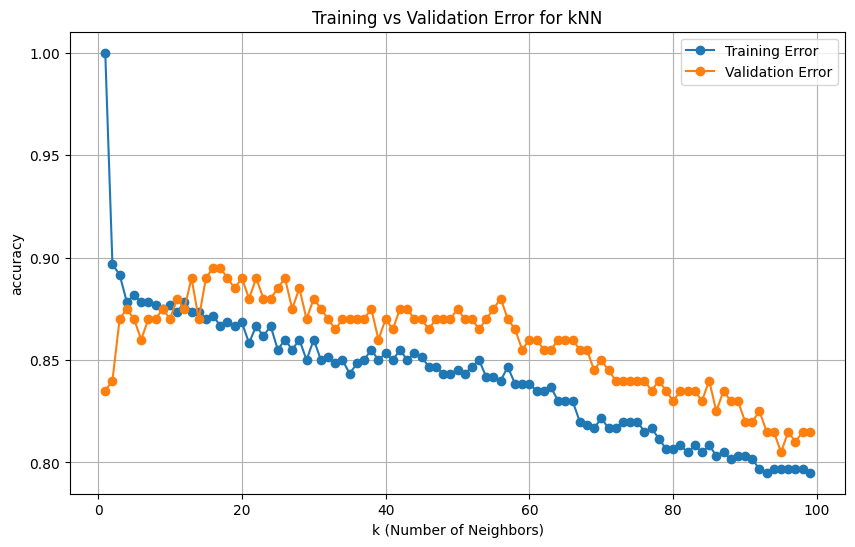

In [366]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_train, label='Training Error', marker='o')
plt.plot(k_range, error_val, label='Validation Error', marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('accuracy')
plt.title('Training vs Validation Error for kNN')
plt.legend()
plt.grid()
plt.show()

K near 20 - 25

### 3. Using cross validation - 25 points

This time, put the test data aside (20% of the data), and apply 5-fold cross-validation (CV) on the remaining data to evaluate the performance of each $k$ value.
What is the size of the validation and training set now, in each CV iteration?
Did your final model selection change? Explain why.

In [247]:
# val,tr,tr,tr,tr,test - error_val_1
# tr,val,tr,tr,tr,test - error_val_2
# tr,tr,val,tr,tr,test - error_val_3 ----> mean_error_val_for_each_k, mean_error_train_for_each_k
# tr,tr,tr,val,tr,test - error_val_4
# tr,tr,tr,tr,val,test - error_val_5

In [367]:
np.random.seed(42)
X, y = generate_data(m=1000)
# random split
indices = np.arange(len(X))
np.random.shuffle(indices)
n_folds = 6

X = X[indices]
y = y[indices]
y = (y + 1) / 2 # minus one to zero

X_split = np.array_split(X, n_folds+1)
y_split = np.array_split(y, n_folds+1)

X_test = X_split[-1:]
y_test = y_split[-1:]

In [368]:
from tqdm import tqdm
k_range = np.arange(1, 100)

def acc(y_pred : np.ndarray, y_fact : np.ndarray) -> float:
    accuracy = np.sum(y_pred==y_fact) / len(y_fact)
    return accuracy

error_val = np.array([])
error_train = np.array([])
for k in tqdm(k_range):
    mean_acc_train = np.array([])
    mean_acc_val = np.array([])
    for i in range(n_folds):
        # print(i)
        X_val, y_val = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[0:i] + X_split[i+1:])
        y_train = np.concatenate(y_split[0:i] + y_split[i+1:])
        knn_class = KNNClassifier(k)
        knn_class.fit(X_train, y_train.astype(int))
        y_pred_train = knn_class.predict(X_train)
        y_pred_val = knn_class.predict(X_val)
        mean_acc_val = np.append(mean_acc_val, acc(y_pred_val, y_val.astype(int)))
        mean_acc_train = np.append(mean_acc_train, acc(y_pred_train, y_train.astype(int)))
    error_val = np.append(error_val, np.mean(mean_acc_val))
    error_train = np.append(error_train, np.mean(mean_acc_train))

100%|██████████| 99/99 [01:01<00:00,  1.61it/s]


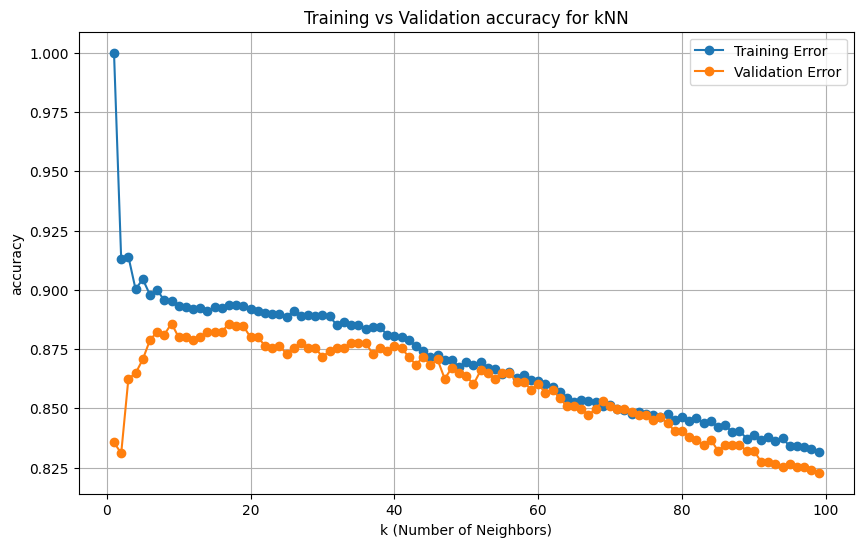

In [369]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_train, label='Training Error', marker='o')
plt.plot(k_range, error_val, label='Validation Error', marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('accuracy')
plt.title('Training vs Validation accuracy for kNN')
plt.legend()
plt.grid()
plt.show()

In [370]:
knn_class = KNNClassifier(10)
knn_class.fit(X_train, y_train.astype(int))
y_pred_train = knn_class.predict(X_train)
y_pred_test = knn_class.predict(X_test[0])
acc(y_test, y_pred_test.astype(int))

0.9154929577464789

As I see we have the same value of accuracy for k from 10 - 20

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html